In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
np.random.seed(28)

import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from typing import Any
from numba import jit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from itertools import product
import copy
import time
import json
import random

In [2]:
root = '/kaggle/input/data-science-bowl-2019/'

train = pd.read_csv(root + 'train.csv')
train_labels = pd.read_csv(root + 'train_labels.csv')
specs = pd.read_csv(root + 'specs.csv')
test = pd.read_csv(root + 'test.csv')

train = train[train.installation_id.isin(train_labels.installation_id.unique())]
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

In [3]:
clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

In [4]:
descr = "how much time elapsed while the game was presenting feedback?"
feedback_ids = specs.loc[specs['info'].str.contains(descr)]['event_id'].values

descr2 = "how much time elapsed while the game was presenting instruction?"
instruction_ids = specs.loc[specs['info'].str.contains(descr2)]['event_id'].values

descr3 = "tutorial"
tutorial_ids = specs.loc[specs['info'].str.contains(descr3)]['event_id'].values

misses_ids = specs.loc[specs['args'].str.contains('misses')]['event_id'].values

id_list_dict = {'feedback_ids':feedback_ids, 'instruction_ids':instruction_ids, 'tutorial_ids':tutorial_ids, 'misses_ids':misses_ids}

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = (list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = (list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = (list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = (list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = (list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour
    train['weekday'] = train['timestamp'].dt.weekday
    test['weekday'] = test['timestamp'].dt.weekday
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0 
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    clip_durations = []
    Activity_durations = []
    Game_durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    
    game_event_code_count: Dict[str, int] = { str(ev) + '_g': 0 for ev in list_of_event_code}
    Activity_event_code_count: Dict[str, int] = {str(ev) + '_A': 0 for ev in list_of_event_code}    
    Activity_sum_event_count = 0
    game_sum_event_count = 0
    get_event_data_dict = {'feedback_ids':0, 'instruction_ids':0, 'tutorial_ids':0, 'misses_ids':0}
 #   event_id_duration_mean = {f'dur_mean_{idx}': 0 for idx in list_of_event_id}
 #   event_id_round = {f'round_{idx}': 0 for idx in list_of_event_id}
 #   event_id_level = {f'level_{idx}': 0 for idx in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    # itarates through each session of one instalation_id
    sessions_count = 0
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]     
        
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = str(k) + '_A'
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            Activity_event_code_count = update_counters(Activity_event_code_count, "event_code")
        
        if session_type == 'Game':
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = str(k) + '_g'
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            game_event_code_count = update_counters(game_event_code_count, "event_code")
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
        #    features.update(event_id_duration_mean.copy())
        #    features.update(event_id_round.copy())
        #    features.update(event_id_level.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(get_event_data_dict)
            features.update()
            features['installation_session_count'] = sessions_count
            features['hour'] = session['hour'].iloc[-1]
            features['weekday'] = session['weekday'].iloc[-1]
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            features['game_sum_event_count'] = game_sum_event_count
            features['Activity_sum_event_count'] = game_sum_event_count
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            if Activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(Activity_durations)
                features['Activity_duration_std'] = np.std(Activity_durations)
                
            if Game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(Game_durations)
                features['Game_duration_std'] = np.std(Game_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
        
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        
        # json data
  #      session['round'] = session['event_data'].apply(lambda x:json.loads(x).get('round', None))
        for id_list in get_event_data_dict.keys():
            if id_list == 'misses':
                just_ids = session.loc[session['event_id'].isin(id_list_dict[f'{id_list}'])]['event_data'].apply(lambda x:json.loads(x).get('misses', None)).sum()
            else:
                just_ids = session.loc[session['event_id'].isin(id_list_dict[f'{id_list}'])]['event_data'].apply(lambda x:json.loads(x).get('duration', None)).mean()
            if just_ids == just_ids:
                get_event_data_dict[f'{id_list}'] += just_ids
                get_event_data_dict[f'{id_list}'] /= 2
        #      session['level'] = session['event_data'].apply(lambda x:json.loads(x).get('level', None))
  #      for idx in session['event_id'].unique():
  #          event_id_duration_mean[f'dur_mean_{idx}'] = event_id_duration_mean[f'dur_mean_{idx}'] + session.loc[session['event_id'] == idx]['durations'].mean()
  #          event_id_round[f'round_{idx}'] = event_id_round[f'round_{idx}'] + session.loc[session['event_id'] == idx]['round'].mean()
  #          event_id_level[f'level_{idx}'] = event_id_level[f'level_{idx}'] + session.loc[session['event_id'] == idx]['level'].mean()
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1], all_assessments[:-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

In [8]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    compiled_test_tr = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 3614):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data, test_data_tr = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
        compiled_test_tr += (test_data_tr)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_test_tr = pd.DataFrame(compiled_test_tr)    
    categoricals = ['session_title']
    return reduce_train, reduce_test, reduce_test_tr, categoricals

In [9]:
reduce_train, reduce_test, reduce_test_tr, categoricals = get_train_and_test(train, test)

In [10]:
def preprocess(reduce_train, reduce_test, reduce_test_tr):
    for df in [reduce_train, reduce_test, reduce_test_tr]:
        df['installation_session_clip_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_session_game_count'] = df.groupby(['installation_id'])['Game'].transform('count')
        df['installation_session_act_count'] = df.groupby(['installation_id'])['Activity'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'game_session']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, reduce_test_tr, features
# call feature engineering function
reduce_train, reduce_test, reduce_test_tr, features = preprocess(reduce_train, reduce_test, reduce_test_tr)

In [11]:
y = reduce_train['accuracy_group']
y_t = reduce_test_tr['accuracy_group']
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
reduce_test_tr.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test_tr.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]

In [12]:
from functools import partial
from sklearn.base import BaseEstimator, TransformerMixin
@jit

def use_coefs(oof, coefs, train_preds=True):
    oof[oof <= coefs[0]] = 0
    oof[np.where(np.logical_and(oof > coefs[0], oof <= coefs[1]))] = 1
    oof[np.where(np.logical_and(oof > coefs[1], oof <= coefs[2]))] = 2
    oof[oof > coefs[2]] = 3
    if train_preds == True:
        return qwk(y, oof)
    else:
        return oof
    
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype='int')
    a2 = np.asarray(a2, dtype='int')

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

def obj_func(guess, y_pred, y_true):
    """
    Fast cappa eval function for lgb.
    """
    s = y_pred.copy()
    s[s <= guess[0]] = 0
    s[np.where(np.logical_and(s > guess[0], s <= guess[1]))] = 1
    s[np.where(np.logical_and(s > guess[1], s <= guess[2]))] = 2
    s[s > guess[2]] = 3
    score = -qwk(s, y_true)
    
    return score

def kappa_funcc(guess, y_pred, y_true):
    """
    Fast cappa eval function for lgb.
    """
    labels = y_true.get_label()
    y_pred[y_pred <= guess[0]] = 0
    y_pred[np.where(np.logical_and(y_pred > guess[0], y_pred <= guess[1]))] = 1
    y_pred[np.where(np.logical_and(y_pred > guess[1], y_pred <= guess[2]))] = 2
    y_pred[y_pred > guess[2]] = 3
    
    return 'cappa', qwk(y_pred, labels), True

def obs(x0, valid_ids, oof, y):
    scores = []
    for h in range(iters):
        scores.append(obj_func(coefs, oof[valid_ids[:,h]], y[valid_ids[:,h]]))
    return np.mean(scores)

In [13]:
feat = [x for x in features if x not in ['installation_id']]
target = ['accuracy_group']
categoricals=[]
duplicates = [k for k,v in Counter(feat).items() if v>1]
feat = list(set(feat) - set(duplicates))
[k for k,v in Counter(feat).items() if v>1]

[]

In [14]:
def train_lgb(params, feat):
    n_fold = 5
    folds = GroupKFold(n_splits=n_fold)
    oof = np.zeros(y.shape[0])
    models = []
    coefs = [1.09122991, 1.75101234, 2.24616994]
    print(len(feat))
    for fold, (tr_idx, v_idx) in enumerate(folds.split(reduce_train, y, reduce_train['installation_id'])):
        print(f'Fold: {fold}\n{"*"*50}')
        X_train, y_train = reduce_train.iloc[tr_idx], y.iloc[tr_idx]
        X_valid, y_valid = reduce_train.iloc[v_idx], y.iloc[v_idx]

        lgb_train = lgb.Dataset(X_train[feat], y_train, categorical_feature=categoricals)
        lgb_valid = lgb.Dataset(X_valid[feat], y_valid, categorical_feature=categoricals)

        gbm_regress = lgb.train(params, lgb_train, verbose_eval=50, valid_sets=[lgb_train, lgb_valid], num_boost_round=5000,
                                early_stopping_rounds=50, categorical_feature=categoricals)
        oof[v_idx] = gbm_regress.predict(X_valid[feat], num_iteration=gbm_regress.best_iteration, random_state=28)
        models.append(gbm_regress)    
    y_pred = sum([model.predict(reduce_test_tr[feat], num_iteration=model.best_iteration) for model in models])/n_fold
    y_true = y_t
    opt2 = sp.optimize.minimize(fun=obj_func, x0=np.array([1.22232214, 1.73925866, 2.22506454]), args=(y_pred, y_true), method='nelder-mead')
    score = opt2.fun
    print(score)
    return score, models, y_pred

In [15]:
drop_cols = ['installation_session_clip_count', 'installation_session_act_count', 'installation_session_game_count']
feat = [x for x in feat if x not in drop_cols]

In [16]:
%%time
features_dict = {}
models_dict = {}
oof_vectors = {}
scores_final = []
params = {'n_estimators':2000,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'subsample': 0.75,
        'subsample_freq': 1,
        'learning_rate': 0.04,
        'feature_fraction': 0.9,
        'max_depth': 15,
        'lambda_l1': 1,  
        'lambda_l2': 1,
        }
n_samples = 12
baseline, _, _ = train_lgb(params, feat)
for i in range(6):
    feats = feat
    base = baseline
    for drops in range(7):
        score = 10
        tracking = 0
        while (score > base) & (tracking < n_samples):
            tracking += 1
            print(f'Iteration: {tracking}')
            poss = [x for x in feats if x not in ['session_title']]
            new_feats = random.sample(poss, k=len(feats)-int(len(feats)/10))
            new_feats.append('session_title')
            score, models, oof = train_lgb(params, new_feats)
        print(f'Score: {score}\nBase: {base}\nNumber of Features: {len(feats)}')
        if score < base:
            base = score
            feats = new_feats
            features_dict[f'{i}_iteration_feat'] = feats
            models_dict[f'{i}_iteration_models'] = models
            oof_vectors[f'{i}_iteration_oof'] = oof
    scores_final.append(score)

898
Fold: 0
**************************************************
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.965464	valid_1's rmse: 1.00602
[100]	training's rmse: 0.90464	valid_1's rmse: 0.982101
[150]	training's rmse: 0.865324	valid_1's rmse: 0.974446
[200]	training's rmse: 0.833874	valid_1's rmse: 0.972825
[250]	training's rmse: 0.807399	valid_1's rmse: 0.973428
Early stopping, best iteration is:
[201]	training's rmse: 0.833429	valid_1's rmse: 0.972675
Fold: 1
**************************************************
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.963387	valid_1's rmse: 1.01672
[100]	training's rmse: 0.903667	valid_1's rmse: 0.99372
[150]	training's rmse: 0.86556	valid_1's rmse: 0.988728
[200]	training's rmse: 0.834314	valid_1's rmse: 0.986625
[250]	training's rmse: 0.80765	valid_1's rmse: 0.986896
Early stopping, best iteration is:
[202]	training's rmse: 0.833171	valid_1's rmse: 0.98632
Fold: 2
***

In [17]:
scores_final

[-0.5497474491018337,
 -0.5568976162372128,
 -0.5496947972479558,
 -0.5514169073509698,
 -0.5492911191636152,
 -0.5452180079340047]

In [18]:
def cappa_combinations(weights, x, y_true):
    y_pred = np.sum(weights * x, axis=1).values
    opt2 = sp.optimize.minimize(fun=obj_func, x0=np.array([1.22232214, 1.73925866, 2.22506454]), args=(y_pred, y_true), method='nelder-mead')
    score = opt2.fun
    return score

In [19]:
weights = [0.3, 0.3, 0.3]
y_pred = np.sum(weights * t[subset], axis=1).values
y_true = y_t
opt2 = sp.optimize.minimize(fun=obj_func, x0=np.array([1.22232214, 1.73925866, 2.22506454]), args=(y_pred, y_true), method='nelder-mead')

NameError: name 't' is not defined

In [20]:
import itertools
blend_scores = {}
t = pd.concat([pd.Series(x) for x in oof_vectors.values()], axis=1)
ls = [i for i in range(len(oof_vectors))]
for subset in itertools.combinations(ls, 3):
    subset = list(subset)
    opt2 = sp.optimize.minimize(fun=cappa_combinations, x0=np.array([0.33, 0.33, 0.33]), args=(t[subset], y_t), method='nelder-mead')
    score = opt2.fun
    print(score)
    blend_score = score
    weights = opt2.x
    print(opt2.x)
    y_pred = np.sum(weights * t[subset], axis=1).values
    opt2 = sp.optimize.minimize(fun=obj_func, x0=np.array([1.22232214, 1.73925866, 2.22506454]), args=(y_pred, y_t), method='nelder-mead')
    coefs = opt2.x
    blend_scores[f'{blend_score}'] = [subset, weights, coefs]
blend_scores

-0.5549513233820582
[0.33755873 0.33061646 0.31659108]
-0.5533273747792369
[0.33712138 0.33546251 0.33079525]
-0.5546318601227356
[0.3142408  0.30685651 0.35966787]
-0.5542593419407478
[0.31357281 0.34115079 0.34119376]
-0.5556718592932078
[0.231      0.36361111 0.33427778]
-0.5537294876771359
[0.32299132 0.35012211 0.32993634]
-0.5531442165639973
[0.33852542 0.33800979 0.32998419]
-0.5542998788737485
[0.32953954 0.34756732 0.33883353]
-0.5528507062418977
[0.36236982 0.32443696 0.33160632]
-0.5522859864699582
[0.32877106 0.33135507 0.34435093]
-0.5562373804133331
[0.33180988 0.32491067 0.3297341 ]
-0.5573367264740174
[0.3286067  0.32303349 0.34233442]
-0.5556751959742146
[0.33928125 0.34867708 0.31384375]
-0.5568070096961413
[0.331375 0.325875 0.325875]
-0.5560647340376101
[0.34677569 0.31815218 0.32146362]
-0.5548333289496873
[0.31592401 0.32026843 0.36855878]
-0.5546518205395901
[0.33205613 0.33009549 0.32732002]
-0.5529029569595278
[0.27896661 0.34918271 0.35698755]
-0.5523027191239

{'-0.5549513233820582': [[0, 1, 2],
  array([0.33755873, 0.33061646, 0.31659108]),
  array([1.25193567, 1.73296352, 2.25106857])],
 '-0.5533273747792369': [[0, 1, 3],
  array([0.33712138, 0.33546251, 0.33079525]),
  array([1.26599403, 1.76805916, 2.23795113])],
 '-0.5546318601227356': [[0, 1, 4],
  array([0.3142408 , 0.30685651, 0.35966787]),
  array([1.241782  , 1.7119018 , 2.23292229])],
 '-0.5542593419407478': [[0, 1, 5],
  array([0.31357281, 0.34115079, 0.34119376]),
  array([1.29831244, 1.73726736, 2.28150297])],
 '-0.5556718592932078': [[0, 2, 3],
  array([0.231     , 0.36361111, 0.33427778]),
  array([1.22280939, 1.66521256, 2.12929602])],
 '-0.5537294876771359': [[0, 2, 4],
  array([0.32299132, 0.35012211, 0.32993634]),
  array([1.28756706, 1.71599609, 2.22106737])],
 '-0.5531442165639973': [[0, 2, 5],
  array([0.33852542, 0.33800979, 0.32998419]),
  array([1.31090169, 1.79526327, 2.29651543])],
 '-0.5542998788737485': [[0, 3, 4],
  array([0.32953954, 0.34756732, 0.33883353]),


In [21]:
comb = blend_scores[min(blend_scores)]
comb

[[0, 4, 5],
 array([0.32877106, 0.33135507, 0.34435093]),
 array([1.27694714, 1.73423123, 2.30371588])]

In [22]:
n_fold = 5
test_preds = pd.DataFrame()
for i in comb[0]:
    models = models_dict[f'{i}_iteration_models']
    feats = features_dict[f'{i}_iteration_feat']
    pred = sum([model.predict(reduce_test[feats], num_iteration=model.best_iteration) for model in models])/n_fold
    test_preds[f'{i}_preds'] = pred

2    343
3    338
0    193
1    126
Name: accuracy_group, dtype: int64
    installation_id  accuracy_group
0    00abaee7        2             
1    01242218        3             
2    017c5718        3             
3    01a44906        3             
4    01bc6cb6        2             
..        ...       ..             
995  fee254cf        3             
996  ff57e602        0             
997  ffc73fb2        2             
998  ffe00ca8        1             
999  ffe774cc        2             

[1000 rows x 2 columns]


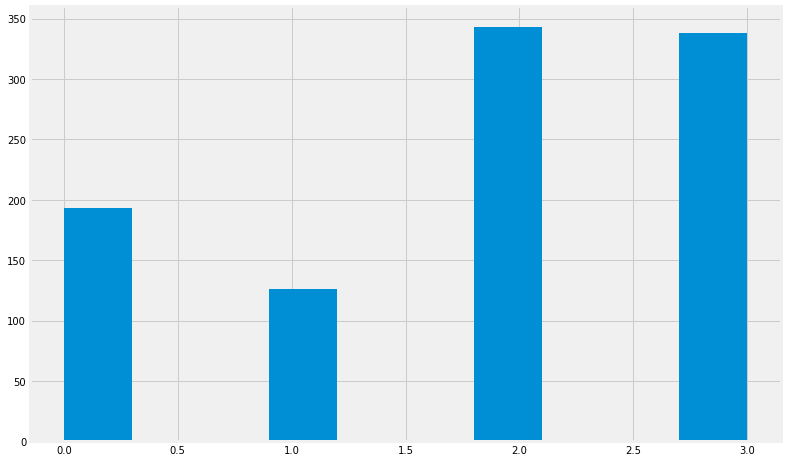

In [23]:
y_pred = np.sum(comb[1] * test_preds.values, axis=1)
y_pred = use_coefs(y_pred, comb[2], train_preds=False)
sample_submission = pd.read_csv(root + 'sample_submission.csv')
sample_submission['accuracy_group'] = y_pred.astype('int')
sample_submission.to_csv('submission.csv', index=False)
print(sample_submission['accuracy_group'].value_counts())
print(sample_submission)
sample_submission['accuracy_group'].hist(figsize=(12, 8))